In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen, AllChem


from sklearn.preprocessing import StandardScaler
#PCA
from sklearn.decomposition import PCA
#TSNE
from sklearn.manifold import TSNE
#UMAP
import umap.umap_ as umap

import lightgbm as lgb


pd.set_option('display.max_colwidth', None)

# Nos données :

In [190]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")
train = train.drop(["Unnamed: 0"], axis = 1)
test = test.drop(["Unnamed: 0"], axis = 1)

In [191]:
train.head(3)

,smiles,label,value
0,CC(C)(O)[C@H](F)CNC(=O)c1cnc(Nc2ccn3nccc3n2)cc1N[C@@H]1CCOC[C@@H]1F,1,8.537602
1,CN(C1CCN(CC1)C(=O)Cn1cc2cc(NC(=O)c3cccc(n3)C(F)(F)F)ccc2n1)C(=O)c1ccncc1,0,6.411168
2,COC(=O)N1CC[C@@H](n2cc(nn2)-c2cnc(cc2NC2CC2)-n2ncc3cc(cnc23)C#N)[C@](C)(O)C1,1,8.221849


In [192]:
test.head(3)

,smiles
0,CC(C)(O)[C@H](F)CNC(=O)c1cnc(cc1N[C@@H]1COCC1(F)F)-n1ccc2cc(cnc12)C#N
1,Cl.Cn1cc(NC(=O)c2cnn3ccc(nc23)N2CCOCC2)c(n1)C(N)=O
2,COc1cc2ncccc2cc1NC(=O)c1csc2cnc(NCC(O)CO)nc12


Affichons les mollécules a l'aide de la bibliotèque rdkit 

In [193]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

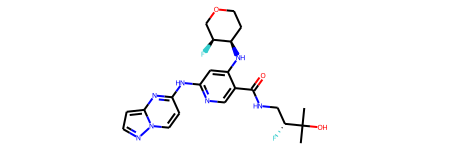

In [194]:
#Nous affichons une mollécules 
mol = Chem.MolFromSmiles(train["smiles"][0])
mol


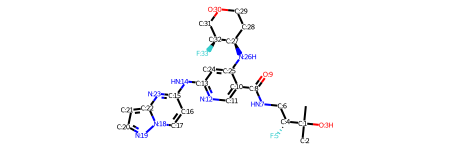

In [195]:
#Affichons une molècules avec leur symbole associé 
mol_with_atom_index(mol)

RDkit fournit une visualisation des MOLs avec le module rdkit.Chem.Draw. 
Visualisons les 10 première molécules 

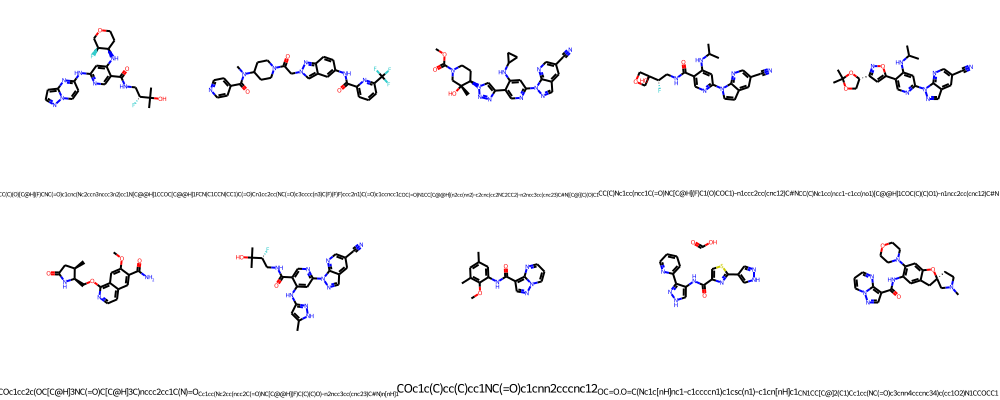

In [198]:
train['mol'] = train['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 
mols = train['mol'][:10]
#MolsToGridImage allows to paint a number of molecules at a time
Chem.Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(train['smiles'][:10].values))

# Représentation de Morgan Fingerprint

Morgan fingerprint est un moyen d'encoder la structure d'une molécule. Le type d'empreinte digitale le plus courant est une série de chiffres binaires (bits) qui représentent la présence ou l'absence de sous-structures particulières dans la molécule.

Nous calculons l'encodage des molécules sur 4096 bits avec un radius de 4

In [8]:
def morgan_finger(df): 
    df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) #Create a rdkit object that allow more manipulation
    
    #Get Morgan Fingerprint transforamtion here with 4 in radius and 4096 bits
    df_morgan = [AllChem.GetMorganFingerprintAsBitVect(x, radius=4, nBits=4096) for x in df['mol']]
    df_morgan_lists = [list(l) for l in df_morgan]
    df_morgan_name = [f'Bit_{i}' for i in range(4096)]
    df_data= pd.DataFrame(df_morgan_lists, index = df['smiles'], columns=df_morgan_name)
    
        
    return df_data



train_data = morgan_finger(train)
test_data = morgan_finger(test)


In [9]:
train_data.head()

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_4086,Bit_4087,Bit_4088,Bit_4089,Bit_4090,Bit_4091,Bit_4092,Bit_4093,Bit_4094,Bit_4095
smiles,,,,,,,,,,,,,,,,,,,,,
CC(C)(O)[C@H](F)CNC(=O)c1cnc(Nc2ccn3nccc3n2)cc1N[C@@H]1CCOC[C@@H]1F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
CN(C1CCN(CC1)C(=O)Cn1cc2cc(NC(=O)c3cccc(n3)C(F)(F)F)ccc2n1)C(=O)c1ccncc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
COC(=O)N1CC[C@@H](n2cc(nn2)-c2cnc(cc2NC2CC2)-n2ncc3cc(cnc23)C#N)[C@](C)(O)C1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC(C)Nc1cc(ncc1C(=O)NC[C@H](F)C1(O)COC1)-n1ccc2cc(cnc12)C#N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC(C)Nc1cc(ncc1-c1cc(no1)[C@@H]1COC(C)(C)O1)-n1ncc2cc(cnc12)C#N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dans ce graph nous visualisons l'encodage des mollécules.Les deux couleurs représentent une sous strucuture de la mollécules 

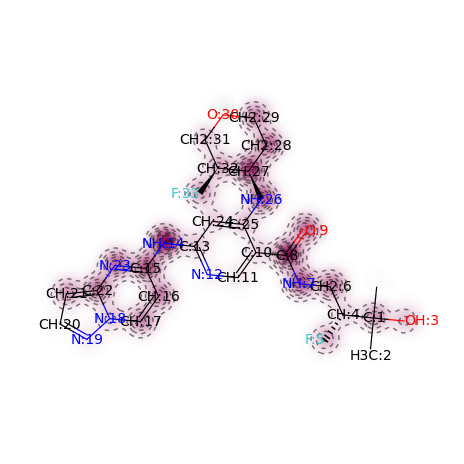

In [10]:
from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(train['mol'][4], mol, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=4, fpType='count'), metric=DataStructs.TanimotoSimilarity)



In [199]:
train['mol'] = train['mol'].apply(lambda x: Chem.AddHs(x))
train['num_of_atoms'] = train['mol'].apply(lambda x: x.GetNumAtoms())
train['num_of_heavy_atoms'] = train['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [12]:

for i in train.index:
    mol=Chem.MolFromSmiles(train.loc[i,'smiles'])
    train.loc[i,'MolWt']=Descriptors.ExactMolWt (mol)
    train.loc[i,'TPSA']=Chem.rdMolDescriptors.CalcTPSA(mol) #Topological Polar Surface Area
    train.loc[i,'nRotB']=Descriptors.NumRotatableBonds (mol) #Number of rotable bonds
    train.loc[i,'HBD']=Descriptors.NumHDonors(mol) #Number of H bond donors
    train.loc[i,'HBA']=Descriptors.NumHAcceptors(mol) #Number of H bond acceptors
    train.loc[i,'LogP']=Descriptors.MolLogP(mol) #LogP
    
    df_features = train.copy()


In [13]:
df_features.head(1)# Des possibles features créées par le package rdkit pour la prédiction

,smiles,label,value,mol,num_of_atoms,num_of_heavy_atoms,MolWt,TPSA,nRotB,HBD,HBA,LogP
0,CC(C)(O)[C@H](F)CNC(=O)c1cnc(Nc2ccn3nccc3n2)cc1N[C@@H]1CCOC[C@@H]1F,1,8.537602,<rdkit.Chem.rdchem.Mol object at 0x7fc997c456c0>,61,34,475.214344,125.7,8.0,4.0,9.0,2.2456


In [14]:
df_features = df_features.drop(['label', 'value','mol'], axis=1)

In [15]:

train_data_std = StandardScaler().fit_transform(train_data)
print("shape Data :", train_data_std.shape)

shape Data : (3200, 4096)


# PCA Reduction

Le principe de réduction de dimension est la transformation des données d'un espace à haute dimension en un espace à basse dimension de sorte que la représentation à basse dimension conserve certaines propriétés significatives des données d'origine.



PCA tente de préserver la structure globale des données, c'est-à-dire que lors de la conversion de données x-dimensionnelles en données x-dimensionnelles, elle tente de cartographier tous les groupes dans leur ensemble, ce qui pourrait entraîner la perte de structures locales.

In [70]:
pca = PCA(n_components=2) # Reduction a deux dimension 
train_data_2d = pca.fit_transform(train_data_std)


In [71]:
df_pca= pd.DataFrame(train_data_2d)
df_pca.index = train.index
df_pca.columns = ['PC{}'.format(i+1) for i in df_pca.columns]
df_pca.head(5)

,PC1,PC2
0,-4.733212,-0.051587
1,6.191897,16.521630
2,-9.761274,-3.042644
3,-9.474027,-3.745928
4,-9.774153,-2.685020


In [72]:
print(pca.explained_variance_ratio_) 
print(sum(pca.explained_variance_ratio_))


[0.01541833 0.01304684]
0.028465174004548642


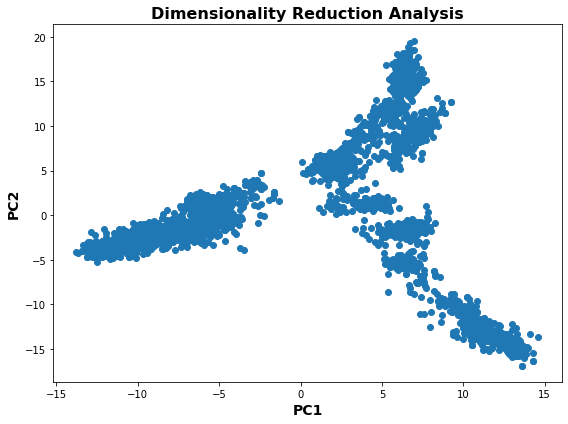

In [24]:
def plot_analysis(df):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)

    ax.plot(df['PC1'],df['PC2'],'o')
    ax.set_title ('Dimensionality Reduction Analysis',fontsize=16,fontweight='bold',family='sans-serif')
    ax.set_xlabel ('PC1',fontsize=14,fontweight='bold')
    ax.set_ylabel ('PC2',fontsize=14,fontweight='bold')


    plt.tight_layout()
    plt.show()
plot_analysis(df_pca)

# T-sne Reduction

T-sne a l'inverse de PCA, tente de préserever la structure locale des données.

In [25]:
tsne = TSNE(verbose=1)
descriptors_tsne = tsne.fit_transform(train_data_std)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3200 samples in 3.206s...
[t-SNE] Computed neighbors for 3200 samples in 87.898s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3200
[t-SNE] Computed conditional probabilities for sample 2000 / 3200
[t-SNE] Computed conditional probabilities for sample 3000 / 3200
[t-SNE] Computed conditional probabilities for sample 3200 / 3200
[t-SNE] Mean sigma: 21.711238
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.206383
[t-SNE] KL divergence after 1000 iterations: 1.609731


In [73]:
df_tsne= pd.DataFrame(descriptors_tsne)
df_tsne.index = train.index
df_tsne.columns = ['PC{}'.format(i+1) for i in df_tsne.columns]
df_tsne.head(5)

,PC1,PC2
0,55.995308,2.042388
1,50.451214,-22.966862
2,16.569138,35.498116
3,4.495940,7.498500
4,-10.902366,23.078632


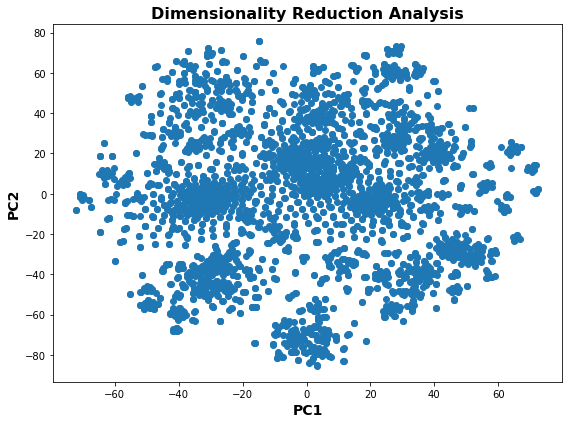

In [27]:
plot_analysis(df_tsne)

# Umap Reduction

Umap réduction est similaire a t-sne, mais il essaye de faire un graph pondéré , les pondérations représentant la probabilité que deux points soient reliés.

In [74]:
model_umap = umap.UMAP(verbose = 1)
descriptors_umap = model_umap.fit_transform(train_data_std)

UMAP(verbose=1)
Construct fuzzy simplicial set
Mon Nov 23 18:00:19 2020 Finding Nearest Neighbors
Mon Nov 23 18:00:21 2020 Finished Nearest Neighbor Search
Mon Nov 23 18:00:21 2020 Construct embedding


/Users/hugo/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Nov 23 18:00:47 2020 Finished embedding


In [29]:
df_umap= pd.DataFrame(descriptors_umap)
df_umap.index = train.index
df_umap.columns = ['PC{}'.format(i+1) for i in df_umap.columns]
df_umap.head(5)

,PC1,PC2
0,9.405541,1.296345
1,6.441139,-7.500287
2,6.222044,1.587959
3,5.694234,-0.346258
4,6.040965,-0.364898
5,8.901176,-2.934955
6,6.452866,-0.415977
7,5.385208,-2.468988
8,6.795265,10.092791
9,4.741365,-2.937332


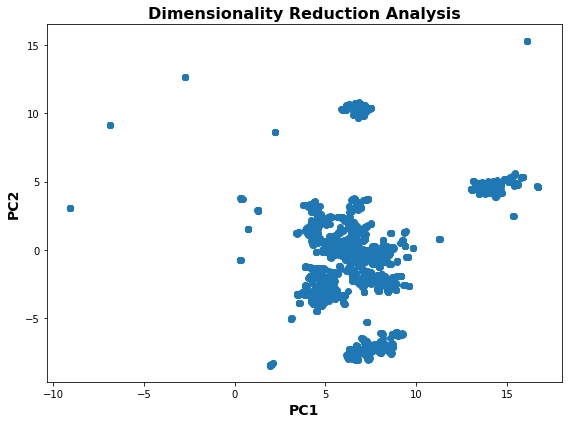

In [30]:
plot_analysis(df_umap)

# K-Means Clustering


Clustering K-means vise à partitionner les données en k-clusters de manière à ce que les points de données dans le même cluster soient similaires et que les points de données dans les différents clusters soient plus éloignés les uns des autres.

In [16]:
#docs https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans


def analysis_cluster(df):
    range_n_clusters = [2, 3, 4, 5, 6, 7,8,9,10]
    for n_clusters in range_n_clusters:
        fig, (ax1,ax2)= plt.subplots(1, 2)
        fig.set_size_inches(8, 4)

        kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = kmeans.fit_predict(df[['PC1','PC2']])
        silhouette_avg = silhouette_score(df[['PC1','PC2']], cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(df[['PC1','PC2']], cluster_labels)

        y_lower = 10

        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(df['PC1'], df['PC2'], 
                    marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')


        # Labeling the clusters
        centers = kmeans.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("PC1")
        ax2.set_ylabel("PC2")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')


    plt.show()
    


L'algorithme K-means n'est pas capable de déterminer le nombre de cluster parfait. 
Nous devons trouver en calculant le score :“silhouette_score“, avec plusieurs k-cluster.


- Le score de silhouette de 1 signifie que les cluster  sont très denses et bien séparées. 
- Un score de 0 signifie que les grappes se chevauchent. 
- Un score inférieur à 0 signifie que les données appartenant aux groupes peuvent être erronées/incorrectes.


For n_clusters = 2 The average silhouette_score is : 0.514569305507375
For n_clusters = 3 The average silhouette_score is : 0.6411410086565554
For n_clusters = 4 The average silhouette_score is : 0.6413773786899654
For n_clusters = 5 The average silhouette_score is : 0.6285222385856176
For n_clusters = 6 The average silhouette_score is : 0.60050441688435
For n_clusters = 7 The average silhouette_score is : 0.596530480379295
For n_clusters = 8 The average silhouette_score is : 0.5617382208923679
For n_clusters = 9 The average silhouette_score is : 0.5469153042472803
For n_clusters = 10 The average silhouette_score is : 0.5406261592282842


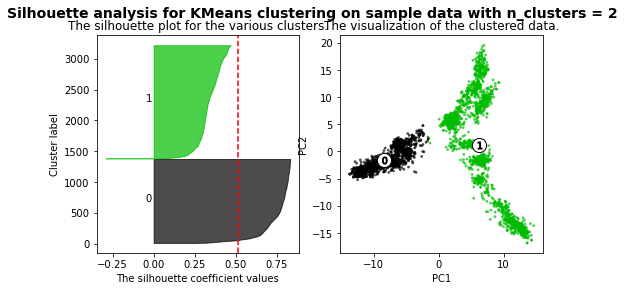

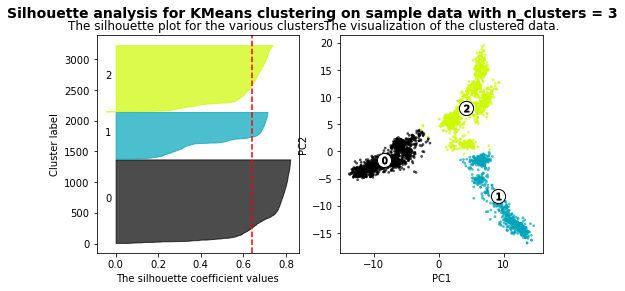

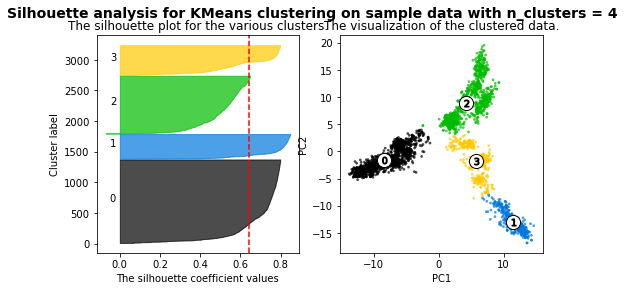

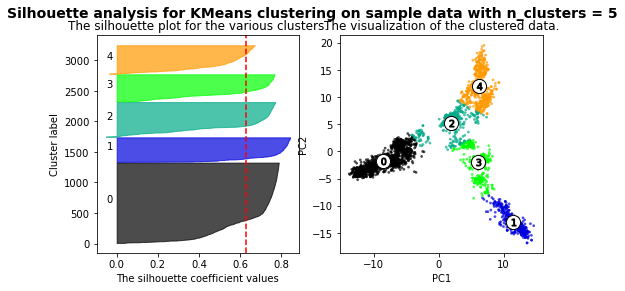

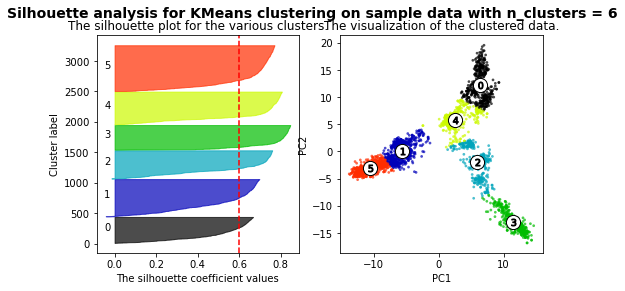

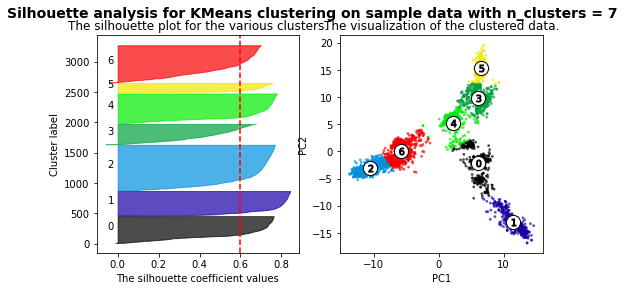

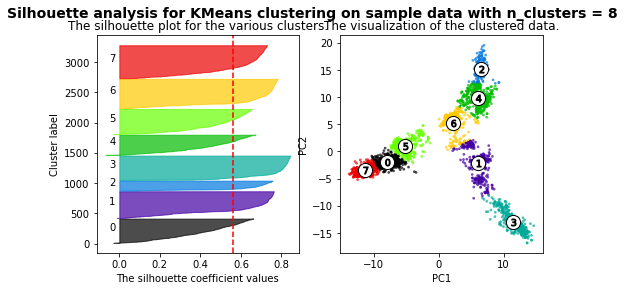

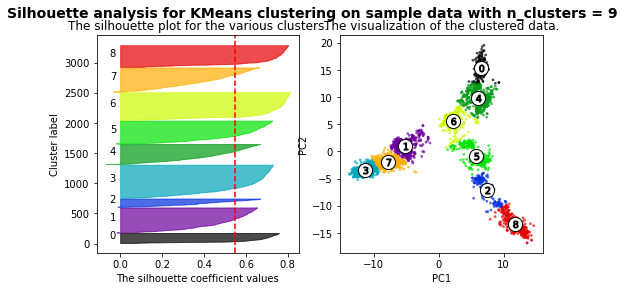

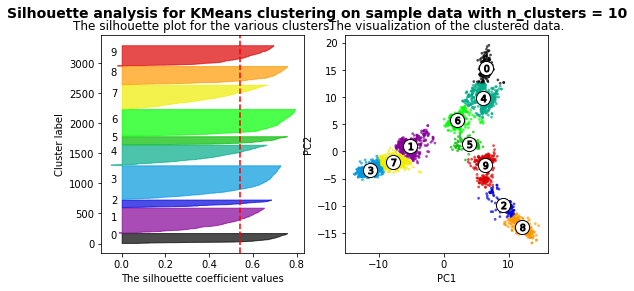

In [36]:
analysis_cluster(df_pca)

For n_clusters = 2 The average silhouette_score is : 0.3521964
For n_clusters = 3 The average silhouette_score is : 0.37103868
For n_clusters = 4 The average silhouette_score is : 0.36645782
For n_clusters = 5 The average silhouette_score is : 0.3724932
For n_clusters = 6 The average silhouette_score is : 0.38754776
For n_clusters = 7 The average silhouette_score is : 0.397897
For n_clusters = 8 The average silhouette_score is : 0.40937302
For n_clusters = 9 The average silhouette_score is : 0.41377643
For n_clusters = 10 The average silhouette_score is : 0.41486344


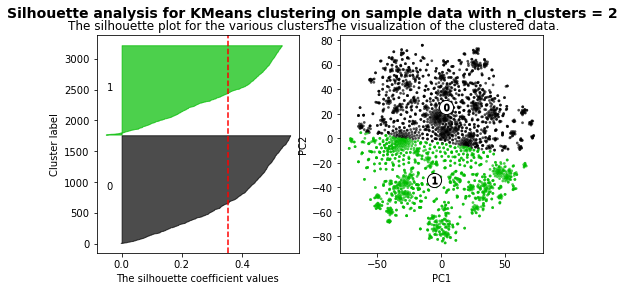

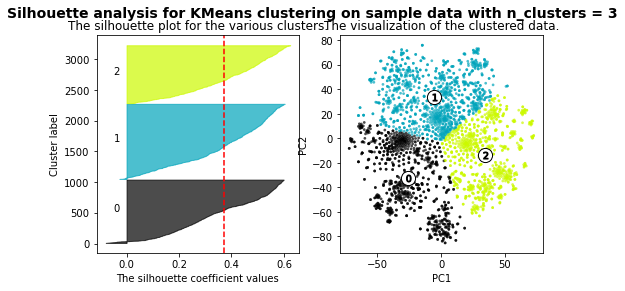

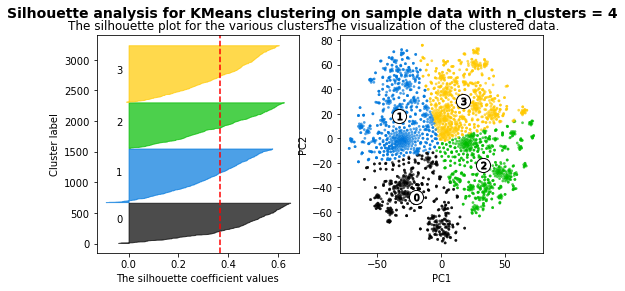

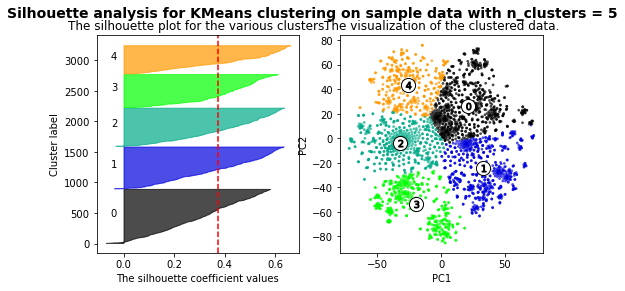

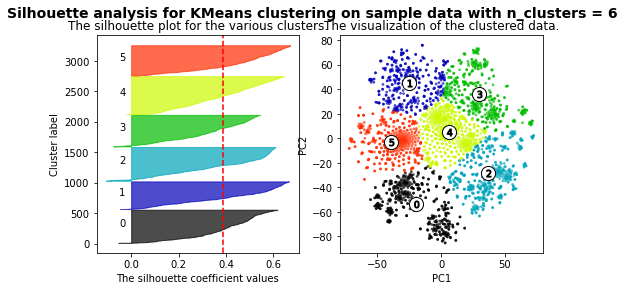

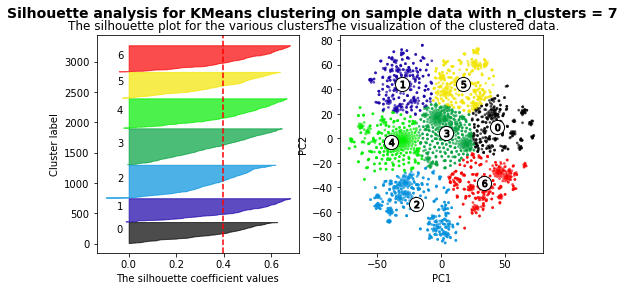

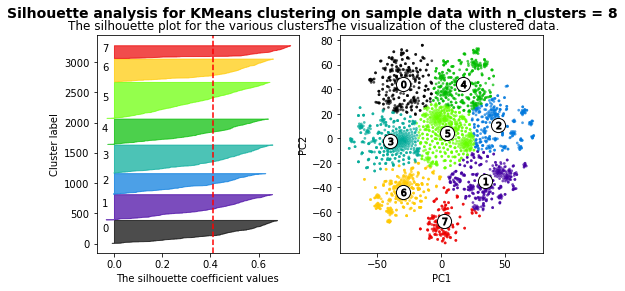

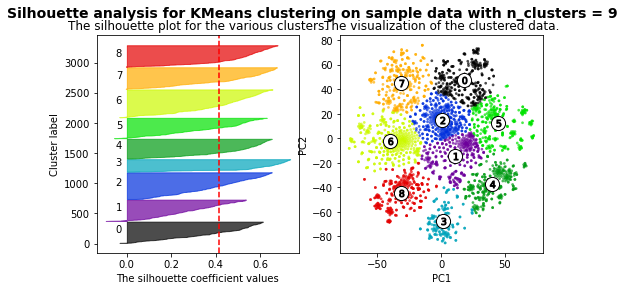

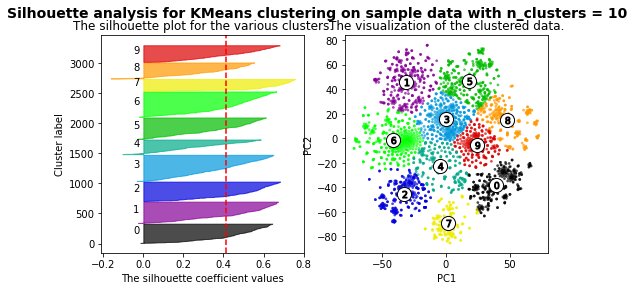

In [37]:
analysis_cluster(df_tsne)

For n_clusters = 2 The average silhouette_score is : 0.58442855
For n_clusters = 3 The average silhouette_score is : 0.4257021
For n_clusters = 4 The average silhouette_score is : 0.488404
For n_clusters = 5 The average silhouette_score is : 0.4919458
For n_clusters = 6 The average silhouette_score is : 0.5321794
For n_clusters = 7 The average silhouette_score is : 0.54993486
For n_clusters = 8 The average silhouette_score is : 0.53734094
For n_clusters = 9 The average silhouette_score is : 0.5454741
For n_clusters = 10 The average silhouette_score is : 0.55842376


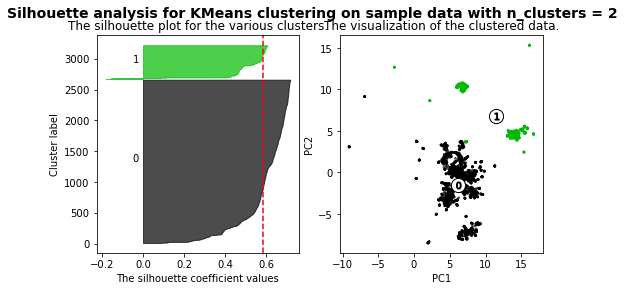

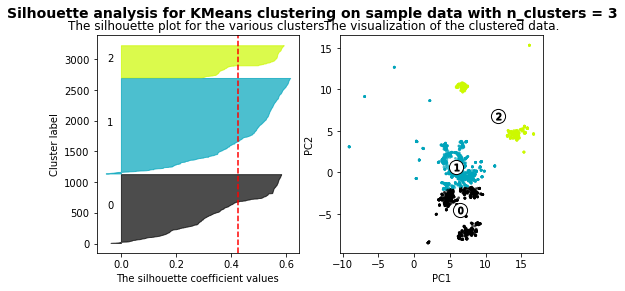

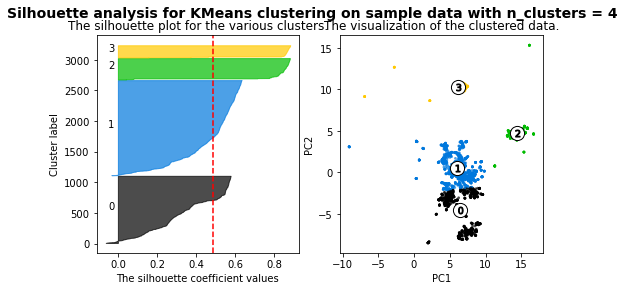

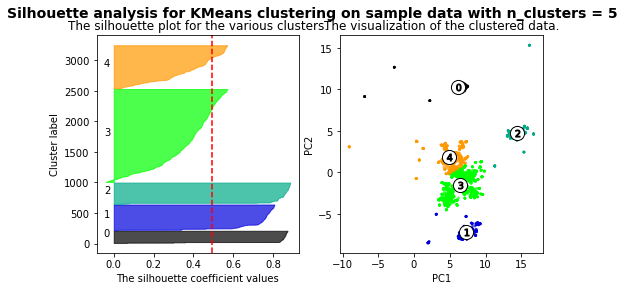

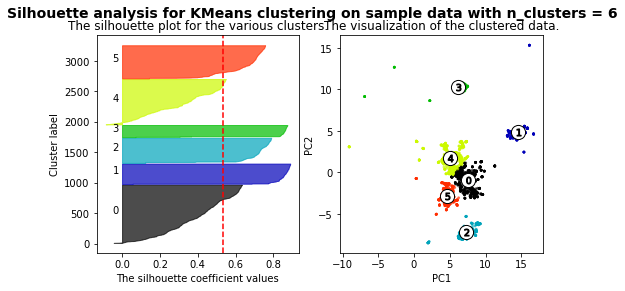

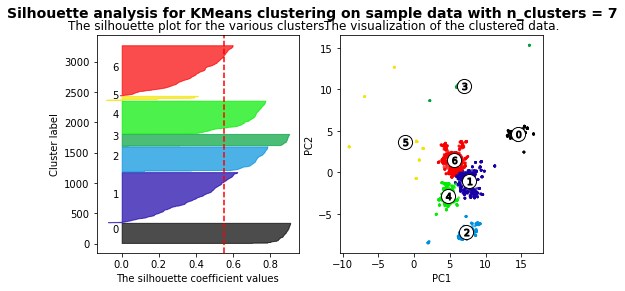

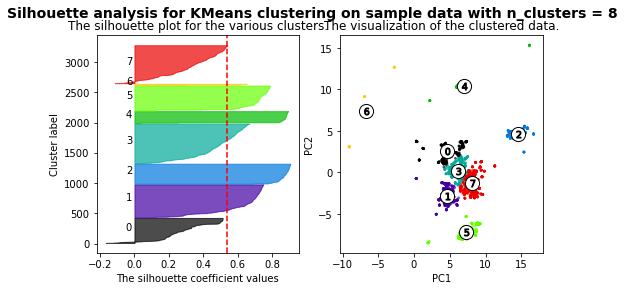

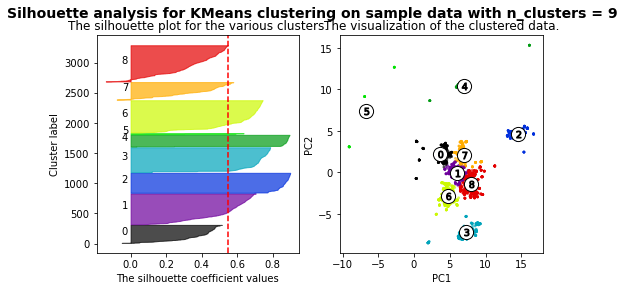

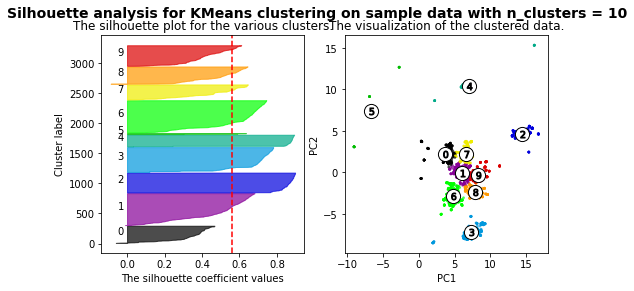

In [38]:
analysis_cluster(df_umap)

En fonction des trois algorithmes, nous pouvons en déduire que le meilleur algorihtmes est le PCA avec 4 cluster 

In [17]:
def make_pca(df):
    pca = PCA(n_components=2)
    df_data_std = StandardScaler().fit_transform(df)
    df_data_2d = pca.fit_transform(df_data_std)

    df_pca= pd.DataFrame(df_data_2d)
    df_pca.index = df.index
    df_pca.columns = ['PC{}'.format(i+1) for i in df_pca.columns]
    df_pca = df_pca.set_index(df.index)

    return df_pca


df_test_pca =  make_pca(test_data)
df_train_pca = make_pca(train_data)

In [18]:
df_train_pca.head(2)

,PC1,PC2
smiles,,
CC(C)(O)[C@H](F)CNC(=O)c1cnc(Nc2ccn3nccc3n2)cc1N[C@@H]1CCOC[C@@H]1F,-4.727414,-0.049327
CN(C1CCN(CC1)C(=O)Cn1cc2cc(NC(=O)c3cccc(n3)C(F)(F)F)ccc2n1)C(=O)c1ccncc1,6.192424,16.525697


In [19]:
def cluster_pca(df):
    kmeans = KMeans(n_clusters=4, random_state=10)
    cluster_labels = kmeans.fit_predict(df[['PC1','PC2']])

    df["cluster"]=  cluster_labels
    df = df.rename({0:"cluster"}, axis=1)
    return df

df_test_cluster = cluster_pca(df_test_pca)
df_train_cluster = cluster_pca(df_train_pca)


In [20]:
df_train_cluster.head(2)

,PC1,PC2,cluster
smiles,,,
CC(C)(O)[C@H](F)CNC(=O)c1cnc(Nc2ccn3nccc3n2)cc1N[C@@H]1CCOC[C@@H]1F,-4.727414,-0.049327,0
CN(C1CCN(CC1)C(=O)Cn1cc2cc(NC(=O)c3cccc(n3)C(F)(F)F)ccc2n1)C(=O)c1ccncc1,6.192424,16.525697,2


# Simple linear regression

In [150]:
#Split train valid
train_try = df_train_cluster[:2200]
valid_try = df_train_cluster[2200:]


In [151]:
y_train = train[['label','value']][:2200]

In [152]:
y_valid = train[['label','value']][2200:]

In [153]:
df_train_cluster.to_csv('train_cluster.csv')

In [154]:
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(train_try,y_train)


val_pred = model_lr.predict(valid_try)
val_score = np.sqrt(mean_squared_error(val_pred, y_valid))
print(f'Our val mse score is {val_score}')



y_pred = model_lr.predict(df_test_pca)




Our val mse score is 0.934775675432649


Avec une simple regression linéaire, nous avons un score mse de 0,93.

# Matrice de corrélation

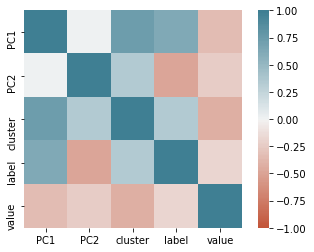

In [155]:
df_corr= df_train_cluster.merge(train[['label','value']],left_on=train.smiles, right_on=df_train_cluster.index)

import seaborn as sns

corr = df_corr.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Les deux targets, label et value sont corrélés.

Nous faisons donc deux modèles et deux prédictions.

# Grid search

In [156]:

params = {
    'application': 'binary', # for binary classification
#     'num_class' : 1, # used for multi-classes
    'boosting': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 100, 
    'learning_rate': 0.05,
    'num_leaves': 62,
    'device': 'cpu', # you can use GPU to achieve faster learning
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'metric' : 'binary_error',
    'subsample_for_bin': 200, # number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5# minimum number of data needed in a leaf
}

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',  
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'])


In [157]:
from sklearn.model_selection import GridSearchCV

gridParams = {
    'learning_rate': [0.001, 0.05, 0.1],
    'num_leaves': [6,12,16], 
    'boosting_type' : ['gbdt', 'dart'], 
    #'subsample' : [0.7,0.8],
    'lambda_l1': [0.1, 0.4, 0.6],
    'cat_smooth': [1, 10, 15]
    }

categorical_features = [c for c in train_try.cluster]


grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(train_try, y_train['label'], categorical_feature=categorical_features)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 162 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 12.1min finished
/Users/hugo/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

{'boosting_type': 'gbdt', 'cat_smooth': 1, 'lambda_l1': 0.1, 'learning_rate': 0.1, 'num_leaves': 6}
0.9327272727272727


# LGBM on label

In [158]:
from sklearn.metrics import mean_squared_error

categorical_features = [c for c in train_try.cluster]

train_data = lgb.Dataset(train_try, label=y_train["label"], categorical_feature=categorical_features)
test_data = lgb.Dataset(valid_try, label=y_valid["label"])

evals_result = {}

parameters = {
    'boosting_type': 'gbdt',
    'metric': 'mse',
    'num_leaves': 40,
    'subsample': 0.7,
    'learning_rate': 0.1,
    'lambda_l1': 0.1
}


model_label = lgb.train(parameters,
                       train_data,
                       valid_sets=[train_data, test_data],
                       num_boost_round=2000,
                       early_stopping_rounds=100,
                       evals_result=evals_result
                       )



/Users/hugo/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	training's l2: 2.40466	valid_1's l2: 2.35357
Training until validation scores don't improve for 100 rounds
[2]	training's l2: 2.08381	valid_1's l2: 2.0309
[3]	training's l2: 1.82744	valid_1's l2: 1.75897
[4]	training's l2: 1.62063	valid_1's l2: 1.54036
[5]	training's l2: 1.4288	valid_1's l2: 1.35198
[6]	training's l2: 1.26549	valid_1's l2: 1.19296
[7]	training's l2: 1.15439	valid_1's l2: 1.0814
[8]	training's l2: 1.04111	valid_1's l2: 0.972395
[9]	training's l2: 0.957979	valid_1's l2: 0.887602
[10]	training's l2: 0.896739	valid_1's l2: 0.826363
[11]	training's l2: 0.82412	valid_1's l2: 0.762222
[12]	training's l2: 0.766021	valid_1's l2: 0.709917
[13]	training's l2: 0.729726	valid_1's l2: 0.672174
[14]	training's l2: 0.700311	valid_1's l2: 0.640822
[15]	training's l2: 0.662855	valid_1's l2: 0.604995
[16]	training's l2: 0.632185	valid_1's l2: 0.575255
[17]	training's l2: 0.607192	valid_1's l2: 0.55121
[18]	training's l2: 0.586712	valid_1's l2: 0.531169
[19]	training's l2: 0.572682	va

[167]	training's l2: 0.366901	valid_1's l2: 0.344231
[168]	training's l2: 0.366745	valid_1's l2: 0.344166
[169]	training's l2: 0.366597	valid_1's l2: 0.343955
[170]	training's l2: 0.366469	valid_1's l2: 0.343843
[171]	training's l2: 0.366252	valid_1's l2: 0.343577
[172]	training's l2: 0.365979	valid_1's l2: 0.343414
[173]	training's l2: 0.36568	valid_1's l2: 0.343095
[174]	training's l2: 0.365518	valid_1's l2: 0.342983
[175]	training's l2: 0.365377	valid_1's l2: 0.343017
[176]	training's l2: 0.365273	valid_1's l2: 0.342915
[177]	training's l2: 0.365124	valid_1's l2: 0.342841
[178]	training's l2: 0.364964	valid_1's l2: 0.342757
[179]	training's l2: 0.364778	valid_1's l2: 0.342388
[180]	training's l2: 0.364627	valid_1's l2: 0.342068
[181]	training's l2: 0.364424	valid_1's l2: 0.341969
[182]	training's l2: 0.364144	valid_1's l2: 0.341965
[183]	training's l2: 0.364032	valid_1's l2: 0.341718
[184]	training's l2: 0.363898	valid_1's l2: 0.341906
[185]	training's l2: 0.363763	valid_1's l2: 0.3

[356]	training's l2: 0.352536	valid_1's l2: 0.33833
[357]	training's l2: 0.352511	valid_1's l2: 0.338358
[358]	training's l2: 0.352483	valid_1's l2: 0.338395
[359]	training's l2: 0.35246	valid_1's l2: 0.338366
[360]	training's l2: 0.352435	valid_1's l2: 0.33842
[361]	training's l2: 0.352405	valid_1's l2: 0.338312
[362]	training's l2: 0.352348	valid_1's l2: 0.33838
[363]	training's l2: 0.352313	valid_1's l2: 0.338346
[364]	training's l2: 0.352299	valid_1's l2: 0.33835
[365]	training's l2: 0.352277	valid_1's l2: 0.338465
[366]	training's l2: 0.35224	valid_1's l2: 0.338483
[367]	training's l2: 0.352208	valid_1's l2: 0.338424
[368]	training's l2: 0.352188	valid_1's l2: 0.338383
[369]	training's l2: 0.352166	valid_1's l2: 0.338342
[370]	training's l2: 0.352146	valid_1's l2: 0.33842
[371]	training's l2: 0.352097	valid_1's l2: 0.338391
[372]	training's l2: 0.352036	valid_1's l2: 0.338296
[373]	training's l2: 0.351993	valid_1's l2: 0.338189
[374]	training's l2: 0.351947	valid_1's l2: 0.338238


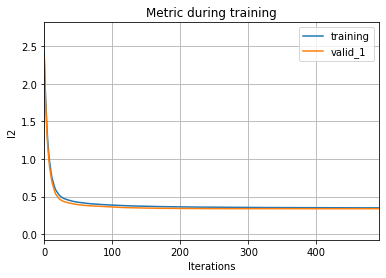

Our val mse score is 0.5809441981371537


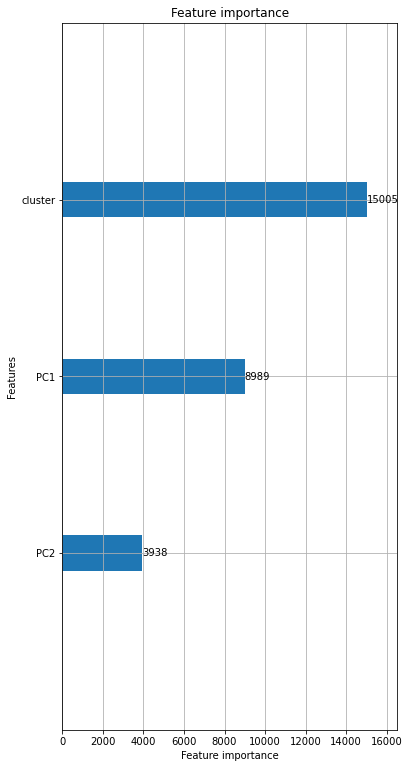

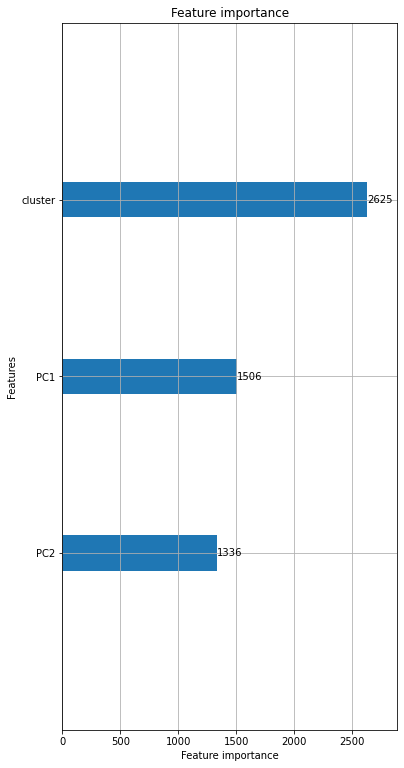

In [159]:
ax = lgb.plot_metric(evals_result)
plt.show()

lgb.plot_importance(model_label, importance_type="gain", precision=0, figsize=(6, 13));
lgb.plot_importance(model_label, importance_type="split", precision=0, figsize=(6, 13));

val_pred = model_label.predict(valid_try, num_iteration=model_label.best_iteration)
val_score = np.sqrt(mean_squared_error(val_pred, y_valid["label"]))
print(f'Our val mse score is {val_score}')


y_pred_label = model_label.predict(df_test_pca, num_iteration=model_label.best_iteration)



# LGBM on value

In [185]:
from sklearn.metrics import mean_squared_error

categorical_features = [c for c in train_try.cluster]

train_data = lgb.Dataset(train_try, label=y_train["value"], categorical_feature=categorical_features)
test_data = lgb.Dataset(valid_try, label=y_valid["value"])

evals_result = {}

parameters = {
    'boosting_type': 'goss',
    'metric': 'mse',
    'num_leaves': 32,
    'subsample': 0.7,
    'learning_rate': 0.01,
    'lambda_l1': 0.001,
    'max_depths':15,
    'min_child_samples': 5
}




model_value = lgb.train(parameters,
                       train_data,
                       valid_sets=[train_data, test_data],
                       num_boost_round=1000,
                       early_stopping_rounds=100,
                       evals_result=evals_result
                       )



/Users/hugo/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/hugo/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[1]	training's l2: 1.00565	valid_1's l2: 1.02934
Training until validation scores don't improve for 100 rounds
[2]	training's l2: 1.00083	valid_1's l2: 1.0243
[3]	training's l2: 0.996107	valid_1's l2: 1.01936
[4]	training's l2: 0.991478	valid_1's l2: 1.01452
[5]	training's l2: 0.986942	valid_1's l2: 1.00976
[6]	training's l2: 0.982453	valid_1's l2: 1.00488
[7]	training's l2: 0.978051	valid_1's l2: 1.00009
[8]	training's l2: 0.973736	valid_1's l2: 0.995399
[9]	training's l2: 0.969421	valid_1's l2: 0.990737
[10]	training's l2: 0.965273	valid_1's l2: 0.986221
[11]	training's l2: 0.961125	valid_1's l2: 0.981738
[12]	training's l2: 0.95706	valid_1's l2: 0.977344
[13]	training's l2: 0.953075	valid_1's l2: 0.973037
[14]	training's l2: 0.949244	valid_1's l2: 0.968859
[15]	training's l2: 0.945413	valid_1's l2: 0.964718
[16]	training's l2: 0.941659	valid_1's l2: 0.960659
[17]	training's l2: 0.938049	valid_1's l2: 0.956719
[18]	training's l2: 0.934412	valid_1's l2: 0.952715
[19]	training's l2: 0.

[167]	training's l2: 0.769157	valid_1's l2: 0.779678
[168]	training's l2: 0.771159	valid_1's l2: 0.783488
[169]	training's l2: 0.770817	valid_1's l2: 0.783025
[170]	training's l2: 0.770065	valid_1's l2: 0.781925
[171]	training's l2: 0.769835	valid_1's l2: 0.781597
[172]	training's l2: 0.769495	valid_1's l2: 0.781024
[173]	training's l2: 0.769225	valid_1's l2: 0.78059
[174]	training's l2: 0.769057	valid_1's l2: 0.780416
[175]	training's l2: 0.768859	valid_1's l2: 0.780011
[176]	training's l2: 0.768845	valid_1's l2: 0.780096
[177]	training's l2: 0.768676	valid_1's l2: 0.779799
[178]	training's l2: 0.768721	valid_1's l2: 0.780209
[179]	training's l2: 0.768403	valid_1's l2: 0.77992
[180]	training's l2: 0.767772	valid_1's l2: 0.779145
[181]	training's l2: 0.767621	valid_1's l2: 0.780494
[182]	training's l2: 0.767388	valid_1's l2: 0.780084
[183]	training's l2: 0.767384	valid_1's l2: 0.780587
[184]	training's l2: 0.767231	valid_1's l2: 0.780207
[185]	training's l2: 0.767464	valid_1's l2: 0.78

[329]	training's l2: 0.7352	valid_1's l2: 0.749647
[330]	training's l2: 0.735184	valid_1's l2: 0.749597
[331]	training's l2: 0.735069	valid_1's l2: 0.749391
[332]	training's l2: 0.735171	valid_1's l2: 0.748467
[333]	training's l2: 0.734961	valid_1's l2: 0.748551
[334]	training's l2: 0.734651	valid_1's l2: 0.748223
[335]	training's l2: 0.734606	valid_1's l2: 0.748322
[336]	training's l2: 0.7345	valid_1's l2: 0.748449
[337]	training's l2: 0.734431	valid_1's l2: 0.748779
[338]	training's l2: 0.734318	valid_1's l2: 0.748868
[339]	training's l2: 0.734166	valid_1's l2: 0.748796
[340]	training's l2: 0.734113	valid_1's l2: 0.749119
[341]	training's l2: 0.73412	valid_1's l2: 0.749207
[342]	training's l2: 0.733924	valid_1's l2: 0.748882
[343]	training's l2: 0.733962	valid_1's l2: 0.74902
[344]	training's l2: 0.733995	valid_1's l2: 0.749197
[345]	training's l2: 0.733788	valid_1's l2: 0.748957
[346]	training's l2: 0.733693	valid_1's l2: 0.748644
[347]	training's l2: 0.733191	valid_1's l2: 0.748101

[518]	training's l2: 0.721873	valid_1's l2: 0.740373
[519]	training's l2: 0.721709	valid_1's l2: 0.740543
[520]	training's l2: 0.721951	valid_1's l2: 0.741188
[521]	training's l2: 0.721996	valid_1's l2: 0.741325
[522]	training's l2: 0.721838	valid_1's l2: 0.741286
[523]	training's l2: 0.721795	valid_1's l2: 0.741062
[524]	training's l2: 0.72175	valid_1's l2: 0.740855
[525]	training's l2: 0.721661	valid_1's l2: 0.740682
[526]	training's l2: 0.721671	valid_1's l2: 0.740811
[527]	training's l2: 0.721718	valid_1's l2: 0.741166
[528]	training's l2: 0.721552	valid_1's l2: 0.741208
[529]	training's l2: 0.721471	valid_1's l2: 0.741317
[530]	training's l2: 0.721347	valid_1's l2: 0.741454
[531]	training's l2: 0.72124	valid_1's l2: 0.741513
[532]	training's l2: 0.721199	valid_1's l2: 0.741436
[533]	training's l2: 0.721189	valid_1's l2: 0.74152
[534]	training's l2: 0.721074	valid_1's l2: 0.741125
[535]	training's l2: 0.721054	valid_1's l2: 0.741124
[536]	training's l2: 0.721087	valid_1's l2: 0.740

[695]	training's l2: 0.714729	valid_1's l2: 0.737044
[696]	training's l2: 0.714751	valid_1's l2: 0.736837
[697]	training's l2: 0.714615	valid_1's l2: 0.736921
[698]	training's l2: 0.714612	valid_1's l2: 0.736589
[699]	training's l2: 0.714513	valid_1's l2: 0.736395
[700]	training's l2: 0.714371	valid_1's l2: 0.736671
[701]	training's l2: 0.714326	valid_1's l2: 0.736375
[702]	training's l2: 0.714326	valid_1's l2: 0.736344
[703]	training's l2: 0.714351	valid_1's l2: 0.736326
[704]	training's l2: 0.714251	valid_1's l2: 0.736078
[705]	training's l2: 0.714085	valid_1's l2: 0.735966
[706]	training's l2: 0.714133	valid_1's l2: 0.737059
[707]	training's l2: 0.714147	valid_1's l2: 0.737234
[708]	training's l2: 0.714148	valid_1's l2: 0.737478
[709]	training's l2: 0.714058	valid_1's l2: 0.737447
[710]	training's l2: 0.714031	valid_1's l2: 0.737509
[711]	training's l2: 0.713999	valid_1's l2: 0.737409
[712]	training's l2: 0.71389	valid_1's l2: 0.73744
[713]	training's l2: 0.713886	valid_1's l2: 0.73

[862]	training's l2: 0.709876	valid_1's l2: 0.732111
[863]	training's l2: 0.709833	valid_1's l2: 0.732277
[864]	training's l2: 0.709911	valid_1's l2: 0.733977
[865]	training's l2: 0.709631	valid_1's l2: 0.7333
[866]	training's l2: 0.709597	valid_1's l2: 0.733167
[867]	training's l2: 0.709581	valid_1's l2: 0.733097
[868]	training's l2: 0.709543	valid_1's l2: 0.732996
[869]	training's l2: 0.709495	valid_1's l2: 0.733267
[870]	training's l2: 0.709474	valid_1's l2: 0.732732
[871]	training's l2: 0.709503	valid_1's l2: 0.733111
[872]	training's l2: 0.709598	valid_1's l2: 0.733788
[873]	training's l2: 0.709633	valid_1's l2: 0.733895
[874]	training's l2: 0.709812	valid_1's l2: 0.733968
[875]	training's l2: 0.709816	valid_1's l2: 0.734278
[876]	training's l2: 0.70986	valid_1's l2: 0.734348
[877]	training's l2: 0.709769	valid_1's l2: 0.734232
[878]	training's l2: 0.709766	valid_1's l2: 0.734157
[879]	training's l2: 0.709806	valid_1's l2: 0.734218
[880]	training's l2: 0.709649	valid_1's l2: 0.734

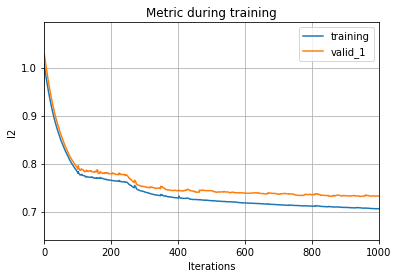

Our val mse score is 0.8559151429033622


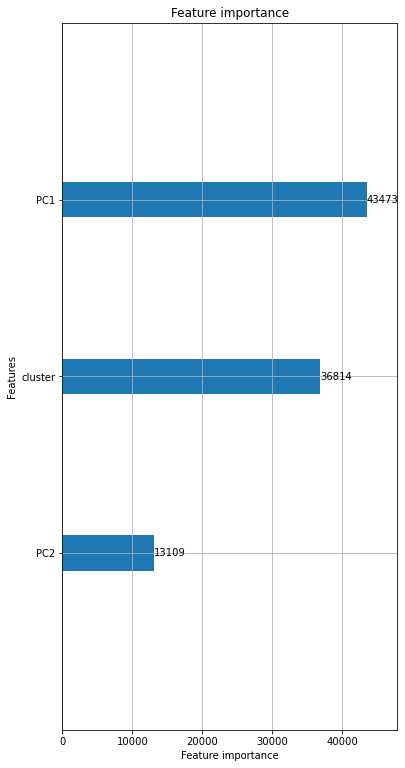

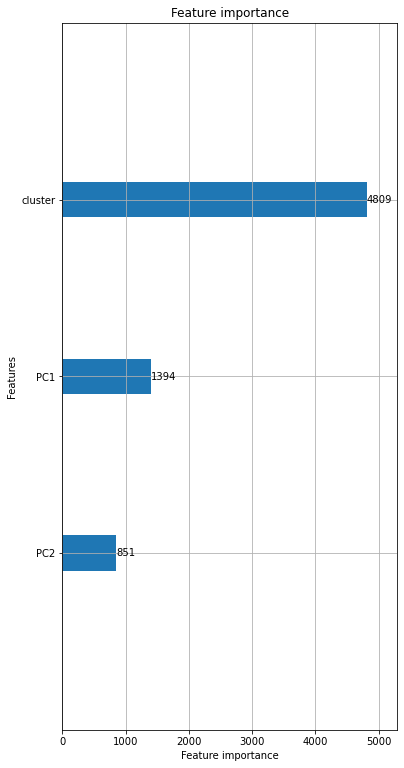

In [186]:
ax = lgb.plot_metric(evals_result)
plt.show()

lgb.plot_importance(model_value, importance_type="gain", precision=0, figsize=(6, 13));
lgb.plot_importance(model_value, importance_type="split", precision=0, figsize=(6, 13));

val_pred = model_value.predict(valid_try, num_iteration=model_value.best_iteration)
val_score = np.sqrt(mean_squared_error(val_pred, y_valid["value"]))
print(f'Our val mse score is {val_score}')


y_pred_value = model_value.predict(df_test_pca, num_iteration=model_value.best_iteration)



In [187]:
test["value"] = y_pred_value
test['label'] = y_pred_label
test.head(3)

,smiles,value,label
0,CC(C)(O)[C@H](F)CNC(=O)c1cnc(cc1N[C@@H]1COCC1(F)F)-n1ccc2cc(cnc12)C#N,7.371420,5.011612
1,Cl.Cn1cc(NC(=O)c2cnn3ccc(nc23)N2CCOCC2)c(n1)C(N)=O,7.238655,1.100021
2,COc1cc2ncccc2cc1NC(=O)c1csc2cnc(NCC(O)CO)nc12,7.721663,1.212287


In [188]:
test.to_csv('test_final.csv')

In [ ]:
from IPython.display import Video

Video("test.mp4")